# Loading the Dataset

## Loading the correct modules

In [123]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import pyarrow as pa
import pyarrow.parquet as pq

In [124]:
dataset = NWBDataset("000129/sub-Indy", "*train", split_heldout=False) # Loading the dataa

In [125]:
np.nanmin(dataset.data.finger_vel.y.to_numpy())

-334.41491272635915

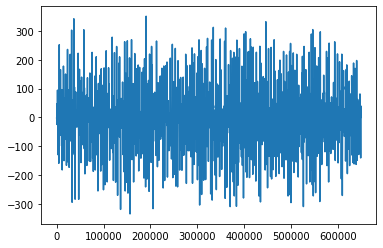

In [126]:
plt.plot(dataset.data.finger_vel.y.to_numpy()[:])

In [111]:
datsplit = dataset.trial_info
datsplit

,trial_id,start_time,end_time,split
0,0,0 days 00:00:00,0 days 00:00:00.600000,train
1,1,0 days 00:00:00.600000,0 days 00:00:01.200000,val
2,2,0 days 00:00:01.200000,0 days 00:00:01.800000,val
3,3,0 days 00:00:01.800000,0 days 00:00:02.400000,train
4,4,0 days 00:00:02.400000,0 days 00:00:03,train
...,...,...,...,...
1075,1075,0 days 00:10:45.900000,0 days 00:10:46.500000,val
1076,1076,0 days 00:10:46.500000,0 days 00:10:47.100000,train
1077,1077,0 days 00:10:47.100000,0 days 00:10:47.700000,train
1078,1078,0 days 00:10:47.700000,0 days 00:10:48.300000,train


In [112]:
dataset.trial_info["split"].value_counts()

train    810
val      270
Name: split, dtype: int64

## Data Cleanup

## Deriving the Training Data

In [113]:
trainingind = (datsplit.split == "val")

In [114]:
trainstarts = datsplit[trainingind].start_time
trainends = datsplit[trainingind].end_time

In [122]:
startintrain = np.isin(dataset.data.index, trainstarts).nonzero()[0]
endintrain = np.isin(dataset.data.index, trainends).nonzero()[0]
print(startintrain.shape)
print(endintrain.shape)

(270,)
(270,)


In [20]:
trainindices = list(zip(startintrain, endintrain + 1))
trainindices = [slice(*i) for i in trainindices]

In [21]:
trdat = dataset.data.iloc[np.r_[(*trainindices,)]]
trdat[:602]

signal_type            cursor_pos            finger_pos                        \
channel                         x          y          x          y          z   
clock_time                                                                      
0 days 00:00:00         -4.368126  56.778511  -4.357695  56.758063  94.737781   
0 days 00:00:00.001000  -4.367445  56.776709  -4.356471  56.755696  94.736662   
0 days 00:00:00.002000  -4.366716  56.774849  -4.355222  56.753297  94.735519   
0 days 00:00:00.003000  -4.365940  56.772930  -4.353950  56.750865  94.734355   
0 days 00:00:00.004000  -4.365118  56.770954  -4.352654  56.748402  94.733168   
...                           ...        ...        ...        ...        ...   
0 days 00:00:00.597000   3.592264  53.162740   4.471563  53.186858  95.740481   
0 days 00:00:00.598000   3.696196  53.156422   4.589246  53.178361  95.745555   
0 days 00:00:00.599000   3.801645  53.150114   4.708405  53.169912  95.750423   
0 days 00:00:00.600000   3.908635  53.143808   4.829045  53.161511  95.755097   
0 days 00:00:01.800000  29.491933  71.684603  27.019079  72.335210  96.913820   

signal_type             finger_vel            spikes            ...            \
channel                          x          y    201  203  204  ... 9201 9203   
clock_time                                                      ...             
0 days 00:00:00           1.211079  -2.349968    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.001000    1.236134  -2.383193    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.002000    1.260579  -2.415633    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.003000    1.284410  -2.447283    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.004000    1.307626  -2.478143    0.0  0.0  0.0  ...  0.0  0.0   
...                            ...        ...    ...  ...  ...  ...  ...  ...   
0 days 00:00:00.597000  116.948651  -8.518965    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.598000  118.421036  -8.472949    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:00.599000  119.899329  -8.425221    0.0  0.0  0.0  ...  1.0  0.0   
0 days 00:00:00.600000  121.383319  -8.375731    0.0  0.0  0.0  ...  0.0  0.0   
0 days 00:00:01.800000 -349.881879  94.394634    0.0  0.0  0.0  ...  0.0  0.0   

signal_type                                          target_pos        
channel                9301 9403 9501 9502 9601 9602          x     y  
clock_time                                                             
0 days 00:00:00         0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.001000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.002000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.003000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
0 days 00:00:00.004000  0.0  0.0  0.0  0.0  0.0  0.0       -7.5  52.5  
...                     ...  ...  ...  ...  ...  ...        ...   ...  
0 days 00:00:00.597000  0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5  
0 days 00:00:00.598000  0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5  
0 days 00:00:00.599000  0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5  
0 days 00:00:00.600000  0.0  0.0  0.0  0.0  0.0  0.0       52.5  67.5  
0 days 00:00:01.800000  0.0  0.0  0.0  0.0  0.0  0.0      -37.5  82.5  

[602 rows x 139 columns]

In [22]:
## Make trial data
# Find when target pos changes
trhas_change = trdat.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
print(trhas_change.index[trhas_change.to_numpy()]) # Times when a change occurs (i.e. when previous one is different, time given)
print(trhas_change.to_numpy().nonzero()[0].size) # Number of changes

TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:00:01.800000',
                '0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.400000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.600000',
                '0 days 00:00:10.220000', '0 days 00:00:11.400000',
                ...
                '0 days 00:10:35.864000', '0 days 00:10:36.940000',
                '0 days 00:10:38.236000', '0 days 00:10:39.296000',
                '0 days 00:10:40.652000', '0 days 00:10:41.644000',
                '0 days 00:10:43.500000', '0 days 00:10:43.732000',
                '0 days 00:10:46.500000', '0 days 00:10:47.924000'],
               dtype='timedelta64[ns]', name='clock_time', length=529, freq=None)
529


In [23]:
# Find if target pos change corresponds to NaN-padded gap between files
trchange_nan = trdat[trhas_change].isna().any(axis=1) # Of all data entries where change, where now at NaN, marked as True
print(trchange_nan.to_numpy().nonzero()) # Indices (within array of changes) where NaN padding ends
print(trhas_change.to_numpy().nonzero()[0][trchange_nan.to_numpy()]) # Timestamps of end of NaN padding
print(trchange_nan)

(array([], dtype=int64),)
[]
clock_time
0 days 00:00:00.252000    False
0 days 00:00:01.800000    False
0 days 00:00:02.712000    False
0 days 00:00:03.952000    False
0 days 00:00:05.400000    False
                          ...  
0 days 00:10:41.644000    False
0 days 00:10:43.500000    False
0 days 00:10:43.732000    False
0 days 00:10:46.500000    False
0 days 00:10:47.924000    False
Length: 529, dtype: bool


In [329]:
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
trdrop_trial = (trchange_nan | trchange_nan.shift(1, fill_value=True) | trchange_nan.shift(-1, fill_value=True))[:-1]
print(trdrop_trial)
print(trdrop_trial.to_numpy().nonzero())

clock_time
0 days 00:00:00.252000     True
0 days 00:00:01.800000    False
0 days 00:00:02.712000    False
0 days 00:00:03.952000    False
0 days 00:00:05.400000    False
                          ...  
0 days 00:10:40.652000    False
0 days 00:10:41.644000    False
0 days 00:10:43.500000    False
0 days 00:10:43.732000    False
0 days 00:10:46.500000    False
Length: 528, dtype: bool
(array([0]),)


In [330]:
# Add start and end times to trial info
trchange_times = trdat.index[trhas_change]
trstart_times = trchange_times[:-1][~trdrop_trial]
trend_times = trchange_times[1:][~trdrop_trial]

In [331]:
print(trchange_times)
print(change_times)

TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:00:01.800000',
                '0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.400000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.600000',
                '0 days 00:00:10.220000', '0 days 00:00:11.400000',
                ...
                '0 days 00:10:35.864000', '0 days 00:10:36.940000',
                '0 days 00:10:38.236000', '0 days 00:10:39.296000',
                '0 days 00:10:40.652000', '0 days 00:10:41.644000',
                '0 days 00:10:43.500000', '0 days 00:10:43.732000',
                '0 days 00:10:46.500000', '0 days 00:10:47.924000'],
               dtype='timedelta64[ns]', name='clock_time', length=529, freq=None)
TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:00:01.352000',
                '0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.112000', '0 days 00:00:06.364000',
             

In [332]:
# Get target position per trial
trtarget_pos = trdat.target_pos.loc[trstart_times].to_numpy().tolist()

In [333]:
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [334]:
dataset.data.target_pos

channel,x,y
clock_time,,
0 days 00:00:00,-7.5,52.5
0 days 00:00:00.001000,-7.5,52.5
0 days 00:00:00.002000,-7.5,52.5
0 days 00:00:00.003000,-7.5,52.5
0 days 00:00:00.004000,-7.5,52.5
...,...,...
0 days 00:10:49.095000,37.5,82.5
0 days 00:10:49.096000,37.5,82.5
0 days 00:10:49.097000,37.5,82.5


In [335]:
trdat.target_pos

channel,x,y
clock_time,,
0 days 00:00:00,-7.5,52.5
0 days 00:00:00.001000,-7.5,52.5
0 days 00:00:00.002000,-7.5,52.5
0 days 00:00:00.003000,-7.5,52.5
0 days 00:00:00.004000,-7.5,52.5
...,...,...
0 days 00:10:48.896000,22.5,22.5
0 days 00:10:48.897000,22.5,22.5
0 days 00:10:48.898000,22.5,22.5


In [336]:
print(end_times)

TimedeltaIndex(['0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.112000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.064000',
                '0 days 00:00:10.220000', '0 days 00:00:11.300000',
                '0 days 00:00:13.004000', '0 days 00:00:14.040000',
                ...
                '0 days 00:10:36.940000', '0 days 00:10:38.236000',
                '0 days 00:10:39.296000', '0 days 00:10:40.652000',
                '0 days 00:10:41.644000', '0 days 00:10:42.864000',
                '0 days 00:10:43.732000', '0 days 00:10:46.496000',
                '0 days 00:10:47.924000', '0 days 00:10:48.984000'],
               dtype='timedelta64[ns]', name='clock_time', length=540, freq=None)


In [337]:
print(trend_times)

TimedeltaIndex(['0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.400000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.600000',
                '0 days 00:00:10.220000', '0 days 00:00:11.400000',
                '0 days 00:00:13.004000', '0 days 00:00:14.040000',
                ...
                '0 days 00:10:35.864000', '0 days 00:10:36.940000',
                '0 days 00:10:38.236000', '0 days 00:10:39.296000',
                '0 days 00:10:40.652000', '0 days 00:10:41.644000',
                '0 days 00:10:43.500000', '0 days 00:10:43.732000',
                '0 days 00:10:46.500000', '0 days 00:10:47.924000'],
               dtype='timedelta64[ns]', name='clock_time', length=527, freq=None)


In [338]:
print(dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')])

channel                    x     y
clock_time                        
0 days 00:00:02.711000 -37.5  82.5
0 days 00:00:03.951000  22.5  67.5
0 days 00:00:05.111000 -22.5   7.5
0 days 00:00:06.363000 -52.5  67.5
0 days 00:00:07.671000 -37.5  52.5
...                      ...   ...
0 days 00:10:42.863000 -52.5  82.5
0 days 00:10:43.731000 -22.5  67.5
0 days 00:10:46.495000  -7.5   7.5
0 days 00:10:47.923000 -52.5  37.5
0 days 00:10:48.983000  22.5  22.5

[540 rows x 2 columns]


In [339]:
print(np.logical_not(np.isin(trend_times- pd.Timedelta(1, 'ms'), trdat.index)).nonzero())

(array([  2,   5,   7,  11,  13,  15,  21,  26,  28,  35,  36,  38,  40,
        46,  48,  51,  69,  82,  86,  91,  93,  95,  96, 101, 106, 109,
       113, 116, 126, 127, 131, 134, 135, 139, 142, 144, 147, 155, 160,
       162, 164, 166, 168, 169, 174, 178, 180, 188, 193, 198, 199, 202,
       211, 217, 221, 227, 229, 230, 231, 233, 244, 251, 253, 258, 262,
       264, 272, 273, 275, 281, 284, 295, 310, 311, 312, 314, 320, 323,
       327, 328, 330, 335, 342, 349, 356, 361, 369, 371, 375, 380, 383,
       387, 388, 391, 396, 399, 406, 408, 415, 417, 419, 425, 435, 439,
       440, 442, 452, 459, 461, 467, 468, 469, 478, 479, 484, 487, 490,
       500, 502, 504, 510, 513, 523, 525]),)


In [340]:
print(trend_times)

TimedeltaIndex(['0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.400000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.600000',
                '0 days 00:00:10.220000', '0 days 00:00:11.400000',
                '0 days 00:00:13.004000', '0 days 00:00:14.040000',
                ...
                '0 days 00:10:35.864000', '0 days 00:10:36.940000',
                '0 days 00:10:38.236000', '0 days 00:10:39.296000',
                '0 days 00:10:40.652000', '0 days 00:10:41.644000',
                '0 days 00:10:43.500000', '0 days 00:10:43.732000',
                '0 days 00:10:46.500000', '0 days 00:10:47.924000'],
               dtype='timedelta64[ns]', name='clock_time', length=527, freq=None)


In [312]:
print(trend_times - pd.Timedelta(1, 'ms'))

TimedeltaIndex(['0 days 00:00:02.711000', '0 days 00:00:03.951000',
                '0 days 00:00:05.399000', '0 days 00:00:06.363000',
                '0 days 00:00:07.671000', '0 days 00:00:09.599000',
                '0 days 00:00:10.219000', '0 days 00:00:11.399000',
                '0 days 00:00:13.003000', '0 days 00:00:14.039000',
                ...
                '0 days 00:10:35.863000', '0 days 00:10:36.939000',
                '0 days 00:10:38.235000', '0 days 00:10:39.295000',
                '0 days 00:10:40.651000', '0 days 00:10:41.643000',
                '0 days 00:10:43.499000', '0 days 00:10:43.731000',
                '0 days 00:10:46.499000', '0 days 00:10:47.923000'],
               dtype='timedelta64[ns]', name='clock_time', length=527, freq=None)


In [279]:
# Compute reach distance and angle
trreach_dist = trdat.target_pos.loc[trend_times - pd.Timedelta(1, 'ms')].to_numpy() - trdat.target_pos.loc[trstart_times - pd.Timedelta(1, 'ms')].to_numpy()
# trreach_angle = np.arctan2(trreach_dist[:, 1], trreach_dist[:, 0]) / np.pi * 180
# # Create trial info
# trtrial_info = pd.DataFrame({
#     'trial_id': np.arange(len(trstart_times)),
#     'start_time': trstart_times,
#     'end_time': trend_times,
#     'target_pos': trtarget_pos,
#     'reach_dist_x': trreach_dist[:, 0],
#     'reach_dist_y': trreach_dist[:, 1],
#     'reach_angle': trreach_angle,
# })

KeyError: "[Timedelta('0 days 00:00:05.399000'), Timedelta('0 days 00:00:09.599000'), Timedelta('0 days 00:00:11.399000'), Timedelta('0 days 00:00:16.799000'), Timedelta('0 days 00:00:19.199000'), Timedelta('0 days 00:00:20.999000'), Timedelta('0 days 00:00:27.599000'), Timedelta('0 days 00:00:33.599000'), Timedelta('0 days 00:00:36.599000'), Timedelta('0 days 00:00:45.599000'), Timedelta('0 days 00:00:46.799000'), Timedelta('0 days 00:00:49.799000'), Timedelta('0 days 00:00:51.599000'), Timedelta('0 days 00:00:58.799000'), Timedelta('0 days 00:01:01.199000'), Timedelta('0 days 00:01:05.399000'), Timedelta('0 days 00:01:27.599000'), Timedelta('0 days 00:01:45.599000'), Timedelta('0 days 00:01:50.399000'), Timedelta('0 days 00:01:55.799000'), Timedelta('0 days 00:01:58.199000'), Timedelta('0 days 00:02:01.799000'), Timedelta('0 days 00:02:02.999000'), Timedelta('0 days 00:02:08.999000'), Timedelta('0 days 00:02:14.999000'), Timedelta('0 days 00:02:19.199000'), Timedelta('0 days 00:02:24.599000'), Timedelta('0 days 00:02:28.799000'), Timedelta('0 days 00:02:41.399000'), Timedelta('0 days 00:02:42.899000'), Timedelta('0 days 00:02:47.699000'), Timedelta('0 days 00:02:50.699000'), Timedelta('0 days 00:02:51.899000'), Timedelta('0 days 00:02:56.699000'), Timedelta('0 days 00:02:59.699000'), Timedelta('0 days 00:03:02.099000'), Timedelta('0 days 00:03:05.099000'), Timedelta('0 days 00:03:16.499000'), Timedelta('0 days 00:03:21.299000'), Timedelta('0 days 00:03:24.299000'), Timedelta('0 days 00:03:27.299000'), Timedelta('0 days 00:03:29.099000'), Timedelta('0 days 00:03:30.899000'), Timedelta('0 days 00:03:33.299000'), Timedelta('0 days 00:03:39.299000'), Timedelta('0 days 00:03:46.499000'), Timedelta('0 days 00:03:50.099000'), Timedelta('0 days 00:04:00.299000'), Timedelta('0 days 00:04:06.299000'), Timedelta('0 days 00:04:12.899000'), Timedelta('0 days 00:04:14.099000'), Timedelta('0 days 00:04:18.299000'), Timedelta('0 days 00:04:29.099000'), Timedelta('0 days 00:04:35.099000'), Timedelta('0 days 00:04:40.499000'), Timedelta('0 days 00:04:47.699000'), Timedelta('0 days 00:04:49.499000'), Timedelta('0 days 00:04:50.699000'), Timedelta('0 days 00:04:51.899000'), Timedelta('0 days 00:04:53.699000'), Timedelta('0 days 00:05:06.899000'), Timedelta('0 days 00:05:15.299000'), Timedelta('0 days 00:05:17.699000'), Timedelta('0 days 00:05:24.599000'), Timedelta('0 days 00:05:28.799000'), Timedelta('0 days 00:05:30.599000'), Timedelta('0 days 00:05:40.199000'), Timedelta('0 days 00:05:41.999000'), Timedelta('0 days 00:05:43.799000'), Timedelta('0 days 00:05:50.999000'), Timedelta('0 days 00:05:53.999000'), Timedelta('0 days 00:06:06.599000'), Timedelta('0 days 00:06:23.999000'), Timedelta('0 days 00:06:27.599000'), Timedelta('0 days 00:06:28.799000'), Timedelta('0 days 00:06:32.399000'), Timedelta('0 days 00:06:40.199000'), Timedelta('0 days 00:06:44.399000'), Timedelta('0 days 00:06:48.599000'), Timedelta('0 days 00:06:49.799000'), Timedelta('0 days 00:06:54.599000'), Timedelta('0 days 00:06:59.999000'), Timedelta('0 days 00:07:08.399000'), Timedelta('0 days 00:07:16.199000'), Timedelta('0 days 00:07:23.399000'), Timedelta('0 days 00:07:29.399000'), Timedelta('0 days 00:07:38.399000'), Timedelta('0 days 00:07:40.799000'), Timedelta('0 days 00:07:46.199000'), Timedelta('0 days 00:07:53.399000'), Timedelta('0 days 00:07:57.599000'), Timedelta('0 days 00:08:01.799000'), Timedelta('0 days 00:08:02.999000'), Timedelta('0 days 00:08:07.499000'), Timedelta('0 days 00:08:12.899000'), Timedelta('0 days 00:08:15.299000'), Timedelta('0 days 00:08:22.499000'), Timedelta('0 days 00:08:24.299000'), Timedelta('0 days 00:08:32.699000'), Timedelta('0 days 00:08:35.699000'), Timedelta('0 days 00:08:37.499000'), Timedelta('0 days 00:08:44.099000'), Timedelta('0 days 00:08:56.699000'), Timedelta('0 days 00:09:00.899000'), Timedelta('0 days 00:09:02.099000'), Timedelta('0 days 00:09:05.699000'), Timedelta('0 days 00:09:17.099000'), Timedelta('0 days 00:09:27.299000'), Timedelta('0 days 00:09:29.099000'), Timedelta('0 days 00:09:36.299000'), Timedelta('0 days 00:09:37.499000'), Timedelta('0 days 00:09:38.699000'), Timedelta('0 days 00:09:49.499000'), Timedelta('0 days 00:09:50.699000'), Timedelta('0 days 00:09:57.299000'), Timedelta('0 days 00:10:00.299000'), Timedelta('0 days 00:10:05.699000'), Timedelta('0 days 00:10:17.699000'), Timedelta('0 days 00:10:20.699000'), Timedelta('0 days 00:10:22.499000'), Timedelta('0 days 00:10:29.099000'), Timedelta('0 days 00:10:32.099000'), Timedelta('0 days 00:10:43.499000'), Timedelta('0 days 00:10:46.499000')] not in index"

In [131]:
## Make trial data
# Find when target pos changes
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
print(has_change.index[has_change.to_numpy()]) # Times when a change occurs (i.e. when previous one is different, time given)
print(has_change.to_numpy().nonzero()[0].size) # Number of changes

TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:00:01.352000',
                '0 days 00:00:02.712000', '0 days 00:00:03.952000',
                '0 days 00:00:05.112000', '0 days 00:00:06.364000',
                '0 days 00:00:07.672000', '0 days 00:00:09.064000',
                '0 days 00:00:10.220000', '0 days 00:00:11.300000',
                ...
                '0 days 00:10:36.940000', '0 days 00:10:38.236000',
                '0 days 00:10:39.296000', '0 days 00:10:40.652000',
                '0 days 00:10:41.644000', '0 days 00:10:42.864000',
                '0 days 00:10:43.732000', '0 days 00:10:46.496000',
                '0 days 00:10:47.924000', '0 days 00:10:48.984000'],
               dtype='timedelta64[ns]', name='clock_time', length=551, freq=None)
551


In [132]:
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1) # Of all data entries where change, where now at NaN, marked as True
print(change_nan.to_numpy().nonzero()) # Indices (within array of changes) where NaN padding ends
print(has_change.to_numpy().nonzero()[0][change_nan.to_numpy()]) # Timestamps of end of NaN padding
print(change_nan)

(array([133, 269, 410]),)
[162200 324500 486800]
clock_time
0 days 00:00:00.252000    False
0 days 00:00:01.352000    False
0 days 00:00:02.712000    False
0 days 00:00:03.952000    False
0 days 00:00:05.112000    False
                          ...  
0 days 00:10:42.864000    False
0 days 00:10:43.732000    False
0 days 00:10:46.496000    False
0 days 00:10:47.924000    False
0 days 00:10:48.984000    False
Length: 551, dtype: bool


In [133]:
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:]
print(drop_trial)
print(drop_trial.to_numpy().nonzero())
print(change_nan.index[drop_trial])

clock_time
0 days 00:00:00.252000     True
0 days 00:00:01.352000    False
0 days 00:00:02.712000    False
0 days 00:00:03.952000    False
0 days 00:00:05.112000    False
                          ...  
0 days 00:10:42.864000    False
0 days 00:10:43.732000    False
0 days 00:10:46.496000    False
0 days 00:10:47.924000    False
0 days 00:10:48.984000     True
Length: 551, dtype: bool
(array([  0, 132, 133, 134, 268, 269, 270, 409, 410, 411, 550]),)
TimedeltaIndex(['0 days 00:00:00.252000', '0 days 00:02:41.264000',
                '0 days 00:02:42.200000', '0 days 00:02:42.300000',
                '0 days 00:05:23.172000', '0 days 00:05:24.500000',
                '0 days 00:05:24.600000', '0 days 00:08:06.672000',
                '0 days 00:08:06.800000', '0 days 00:08:06.900000',
                '0 days 00:10:48.984000'],
               dtype='timedelta64[ns]', name='clock_time', freq=None)


In [134]:
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]

IndexError: Boolean index has wrong length: 551 instead of 550

In [135]:
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()

In [136]:
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [137]:
dataset.trial_info

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
0,0,0 days 00:00:01.352000,0 days 00:00:02.712000,"[-37.5, 82.5]",-90.0,15.0,170.537678
1,1,0 days 00:00:02.712000,0 days 00:00:03.952000,"[22.5, 67.5]",60.0,-15.0,-14.036243
2,2,0 days 00:00:03.952000,0 days 00:00:05.112000,"[-22.5, 7.5]",-45.0,-60.0,-126.869898
3,3,0 days 00:00:05.112000,0 days 00:00:06.364000,"[-52.5, 67.5]",-30.0,60.0,116.565051
4,4,0 days 00:00:06.364000,0 days 00:00:07.672000,"[-37.5, 52.5]",15.0,-15.0,-45.000000
...,...,...,...,...,...,...,...
535,535,0 days 00:10:41.644000,0 days 00:10:42.864000,"[-52.5, 82.5]",-105.0,0.0,180.000000
536,536,0 days 00:10:42.864000,0 days 00:10:43.732000,"[-22.5, 67.5]",30.0,-15.0,-26.565051
537,537,0 days 00:10:43.732000,0 days 00:10:46.496000,"[-7.5, 7.5]",15.0,-60.0,-75.963757
538,538,0 days 00:10:46.496000,0 days 00:10:47.924000,"[-52.5, 37.5]",-45.0,30.0,146.309932


In [50]:
dataset.trial_info.iloc[:135]

,trial_id,start_time,end_time,target_pos,reach_dist_x,reach_dist_y,reach_angle
0,0,0 days 00:00:01.352000,0 days 00:00:02.712000,"[-37.5, 82.5]",-90.0,15.0,170.537678
1,1,0 days 00:00:02.712000,0 days 00:00:03.952000,"[22.5, 67.5]",60.0,-15.0,-14.036243
2,2,0 days 00:00:03.952000,0 days 00:00:05.112000,"[-22.5, 7.5]",-45.0,-60.0,-126.869898
3,3,0 days 00:00:05.112000,0 days 00:00:06.364000,"[-52.5, 67.5]",-30.0,60.0,116.565051
4,4,0 days 00:00:06.364000,0 days 00:00:07.672000,"[-37.5, 52.5]",15.0,-15.0,-45.000000
...,...,...,...,...,...,...,...
130,130,0 days 00:02:40.272000,0 days 00:02:41.264000,"[-22.5, 67.5]",-15.0,-45.0,-108.434949
131,131,0 days 00:02:42.744000,0 days 00:02:43.736000,"[22.5, 112.5]",15.0,15.0,45.000000
132,132,0 days 00:02:43.736000,0 days 00:02:44.808000,"[22.5, 37.5]",0.0,-75.0,-90.000000
133,133,0 days 00:02:44.808000,0 days 00:02:46.140000,"[52.5, 37.5]",30.0,0.0,0.000000


In [138]:
dataset.data.finger_vel.y[dataset.data.index == dataset.trial_info.start_time.iloc[0]]

clock_time
0 days 00:00:01.352000    1.402503
Name: y, dtype: float64

In [10]:
print(dataset.trial_info.iloc[0].start_time)
print(dataset.trial_info.iloc[-1].end_time)
print(((-dataset.trial_info.iloc[0].start_time + dataset.trial_info.iloc[-1].end_time)/np.timedelta64(1, 's'))/0.001)

0 days 00:00:01.352000
0 days 00:10:48.984000
647631.9999999999


In [11]:
print(dataset.trial_info.iloc[270].end_time)
print((dataset.trial_info.iloc[270].end_time/np.timedelta64(1, 's'))/0.001)

0 days 00:05:32.272000
332272.0


In [43]:
finger_posdata = dataset.data.loc[dataset.trial_info.iloc[0].start_time : dataset.trial_info.iloc[130].end_time].drop(['cursor_pos', 'finger_vel', 'target_pos', ('finger_pos', 'z')], axis = 1)

In [26]:
finger_veldata = dataset.data.loc[dataset.trial_info.iloc[0].start_time : dataset.trial_info.iloc[270].end_time].drop(['cursor_pos', 'target_pos', 'finger_pos'], axis = 1)

In [42]:
print(finger_posdata.dropna().finger_pos.to_numpy().shape)

(647333, 2)


In [27]:
finger_veldata.to_hdf('./Data/finger_veldata.h5', 'data')
finger_veldata.to_pickle('./Data/finger_veldata', protocol=4)

In [44]:
finger_posdata.to_hdf('./Data/finger_posdata.h5', 'data')
finger_posdata.to_pickle('./Data/finger_posdata', protocol=4)

/home/sgome/Project/Bayesian-Convolutional-Model/Simple-Model/.venv/lib/python3.8/site-packages/pandas/io/pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0_level1] [items->None]

  f = lambda store: store.put(
/home/sgome/Project/Bayesian-Convolutional-Model/Simple-Model/.venv/lib/python3.8/site-packages/pandas/io/pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items_level1] [items->None]

  f = lambda store: store.put(
/home/sgome/Project/Bayesian-Convolutional-Model/Simple-Model/.venv/lib/python3.8/site-packages/pandas/io/pytables.py:296: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_items_level1] [it

In [ ]:
#dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1)
Nandata = dataset.data.finger_pos[dataset.data.target_pos.isna().any(axis=1)]

#dataset.data.target_pos.isna().any()

In [ ]:
data = dataset.data[["finger_pos", "spikes"]].drop(("finger_pos", "z"), axis=1)
test = data.finger_pos.isna().any(axis=1)
# subset = data.iloc[:100]["finger_pos"]
# subset.x.isna().any()